# Cat and dog classification and detection - machine learning model from scratch

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import os
from tensorflow import keras
import xml.etree.ElementTree as ET
import glob
from PIL import Image
import albumentations as A

# Loading Data

In [3]:
NEGATIVE_CLASS = "no-object"
def xml_to_df(path, skipNegatives):
    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        if root.find('object'):
            for member in root.findall('object'):
                bbx = member.find('bndbox')                
                xmin = round(float(bbx.find('xmin').text))
                ymin = round(float(bbx.find('ymin').text))
                xmax = round(float(bbx.find('xmax').text))
                ymax = round(float(bbx.find('ymax').text))
                label = member.find('name').text
                value = (root.find('filename').text,
                        int(root.find('size')[0].text),
                        int(root.find('size')[1].text),
                        label,
                        xmin,
                        ymin,
                        xmax,
                        ymax
                        )
                xml_list.append(value)
        elif not skipNegatives:
            value = (root.find('filename').text,
                        int(root.find('size')[0].text),
                        int(root.find('size')[1].text),
                        NEGATIVE_CLASS,
                        0,
                        0,
                        0,
                        0
                        )
            xml_list.append(value)

    column_name = ['filename', 'width', 'height',
                   'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df

In [4]:
SKIP_NEGATIVES = False
train_full = []
path_xml = os.path.join(os.getcwd(), 'cat_dog_dataset','annotations')
path_images = os.path.join(os.getcwd(), 'cat_dog_dataset','images')
data_df = xml_to_df(path_xml, SKIP_NEGATIVES)

In [5]:
data_df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,Cats_Test2531.png,500,333,dog,10,5,457,305
1,Cats_Test1038.png,375,500,cat,102,15,272,204
2,Cats_Test134.png,300,225,dog,84,31,216,171
3,Cats_Test1986.png,375,500,dog,160,59,256,179
4,Cats_Test652.png,500,332,cat,250,40,486,242


In [6]:
classes = ['cat', 'dog']
images = []
bounding_boxes = []
labels = []
width_height = []
for index,data in data_df.iterrows():
    width = data['width']
    height = data['height']
    if width == 0 or height == 0:
        continue
    path_to_image = os.path.join(path_images, data['filename'])
    image = keras.preprocessing.image.load_img(path_to_image)
    image = keras.preprocessing.image.img_to_array(image)
    image = image/255.
    width_height.append((width, height))
    xmin = data['xmin']
    xmax = data['xmax']
    ymin = data['ymin']
    ymax = data['ymax']
    labels.append(classes.index(data['class']))
    images.append(image)
    bounding_boxes.append((xmin,ymin,xmax,ymax))

In [7]:
def get_scaled_bounding_boxes(xmin,ymin,xmax,ymax,width,height):
    return int(xmin*width), int(ymin*height), int(xmax*width), int(ymax*width)

In [8]:
def plot_image_with_bbox(img, bbox, sizes, scaled = False):
    width, height = sizes
    xmin,ymin,xmax,ymax = bbox
    if scaled == False:
        xmin, ymin, xmax, ymax = get_scaled_bounding_boxes(xmin,ymin,xmax,ymax,width, height)
    pt1=(int(xmin),int(ymin))
    pt2=(int(xmax),int(ymax))
    img_rectangle  = cv2.rectangle(img.copy(), pt1, pt2, (0,0,1), 4)
    plt.imshow(img_rectangle)

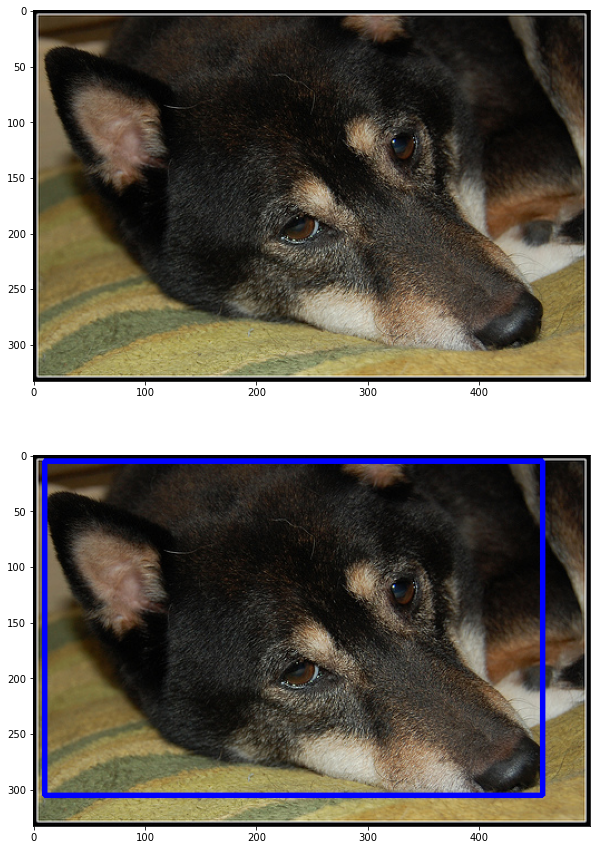

In [9]:
fig = plt.figure(figsize = (15,15))
fig.add_subplot(2, 1, 1)
plt.imshow(images[0])




fig.add_subplot(2, 1, 2)
plot_image_with_bbox(images[0], bounding_boxes[0],width_height[0], scaled=True )

In [10]:
images = np.array(images)
bounding_boxes = np.array(bounding_boxes)
labels = np.array(labels)
width_height = np.array(width_height)

/var/folders/m1/6g6dzl5508ld58b_7x7xlf4h0000gn/T/ipykernel_28679/1466922968.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  images = np.array(images)


## Data processing

In [11]:
def resize_image(img_arr, bboxes, h, w):
    transform = A.Compose(
        [A.Resize(height=h, width=w, always_apply=True)],
        bbox_params=A.BboxParams(format='pascal_voc'))

    transformed = transform(image=img_arr, bboxes=bboxes)

    return transformed

In [12]:
def flip_image(img_arr, bboxes):
    transform = A.Compose(
      [A.HorizontalFlip(p=1)], bbox_params=A.BboxParams(format='pascal_voc'))

    transformed = transform(image=img_arr,bboxes= bboxes)
    return transformed

In [13]:
def rotate_image(img_arr, bbox):
    transform = A.Compose(
      [A.Rotate(p=1)], bbox_params = A.BboxParams(format='pascal_voc')
      )
    transformed = transform(image=img_arr, bboxes=bbox)
    return transformed

In [14]:
bound_index = int(labels.size*0.8)
train_images_full = images[:bound_index]
train_labels_full = labels[:bound_index]
train_bounding_boxes_full = bounding_boxes[:bound_index]
train_width_height_full = width_height[:bound_index]
test_images = images[bound_index:]
test_labels = labels[bound_index:]
test_bounding_boxes = bounding_boxes[bound_index:]
test_width_height = width_height[bound_index:]

In [15]:
labels.size == train_labels_full.size +test_labels.size

True

## Data augmentation

In [16]:
train_images_full_list = train_images_full.tolist()
train_bounding_boxes_full_list = train_bounding_boxes_full.tolist()
train_labels_full_list = train_labels_full.tolist()
train_width_height_list = train_width_height_full.tolist()
for i,image_bbox in enumerate(zip(train_images_full, train_bounding_boxes_full)):
    image, bbox = image_bbox
    bbox = np.append(bbox, 0)
    bbox = bbox.reshape(1,5)
    transformed = flip_image(image, bbox)
    xmin, ymin, xmax,ymax,null =  transformed['bboxes'][0]
    train_bounding_boxes_full_list.append((xmin,ymin,xmax,ymax))
    train_images_full_list.append(transformed['image'])
    train_labels_full_list.append(train_labels_full[i])
    train_width_height_list.append(train_width_height_full[i])
train_bounding_boxes_full = np.array(train_bounding_boxes_full_list)
train_images_full = np.array(train_images_full_list)
train_labels_full = np.array(train_labels_full_list)
train_width_height_full = np.array(train_width_height_list)

/var/folders/m1/6g6dzl5508ld58b_7x7xlf4h0000gn/T/ipykernel_28679/2304101157.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train_images_full = np.array(train_images_full_list)


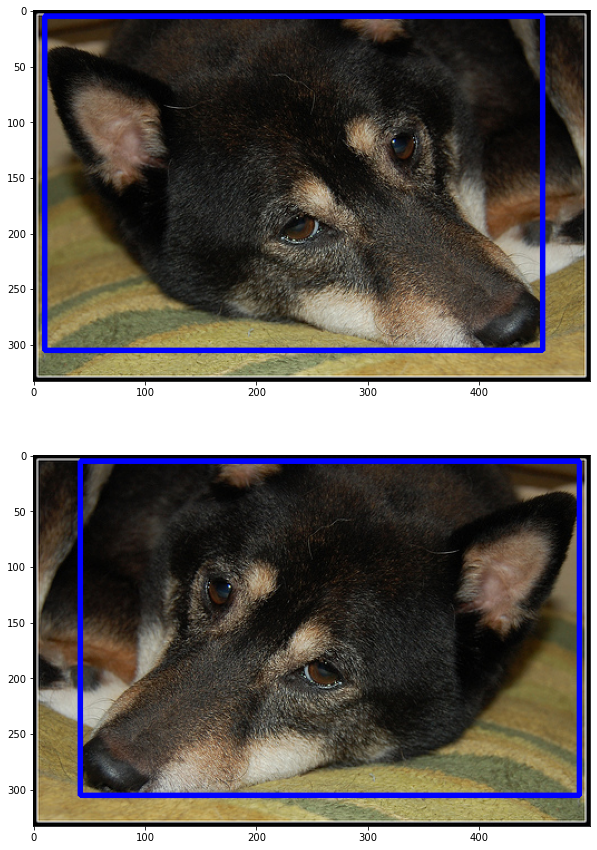

In [17]:
fig = plt.figure(figsize = (15,15))
fig.add_subplot(2, 1, 1)
plot_image_with_bbox(train_images_full[0], train_bounding_boxes_full[0],train_width_height_full[0],scaled=True )




fig.add_subplot(2, 1, 2)
plot_image_with_bbox(train_images_full[2949], train_bounding_boxes_full[2949],train_width_height_full[2949],scaled=True )

In [28]:
i=0
train_bounding_boxes_full_resized = []
for size, width_height in zip(train_bounding_boxes_full,train_width_height_full):
    width, height = width_height
    size = size.astype(np.float64)
    size[0] = np.float64(size[0]/width)
    size[1] = np.float64(size[1]/height)
    size[2] = np.float64(size[2]/width)
    size[3] = np.float64(size[3]/height)
    train_bounding_boxes_full_resized.append(size)
train_bounding_boxes_full = np.array(train_bounding_boxes_full_resized)

In [29]:
train_images_full_resized = []
for img in  train_images_full:
    train_images_full_resized.append(tf.image.resize(img, [224,224]))
train_images_full_resized = np.array(train_images_full_resized)

2021-11-29 10:15:27.963160: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-11-29 10:15:27.963340: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1


In [33]:
bound_index = int(train_labels_full.size*0.85)
train_images = train_images_full_resized[:bound_index]
valid_images = train_images_full_resized[bound_index:]
train_bounding_boxes = train_bounding_boxes_full[:bound_index]
valid_bounding_boxes = train_bounding_boxes_full[bound_index:]
train_labels = train_labels_full[:bound_index]
valid_labels = train_labels_full[bound_index:]

# Model architecture based on VGG19

In [3]:


#input
input_ = keras.layers.Input(shape = (224,224,3))

#base_layers
base_layer_ = keras.layers.Conv2D(64,3,activation='relu', padding="same")(input_)
base_layer_ = keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2))(base_layer_)
base_layer_ = keras.layers.Conv2D(128,3,activation='relu', padding="same")(base_layer_)
base_layer_ = keras.layers.Conv2D(128,3,activation='relu', padding="same")(base_layer_)
base_layer_ = keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2))(base_layer_)
base_layer_ = keras.layers.Conv2D(256,3, activation='relu', padding='same')(base_layer_)
base_layer_ = keras.layers.Conv2D(256,3, activation='relu', padding='same')(base_layer_)
base_layer_ = keras.layers.Conv2D(256,3, activation='relu', padding='same')(base_layer_)
base_layer_ = keras.layers.Conv2D(256,3, activation='relu', padding='same')(base_layer_)
base_layer_ = keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2))(base_layer_)
base_layer_ = keras.layers.Conv2D(512,3, activation='relu', padding='same')(base_layer_)
base_layer_ = keras.layers.Conv2D(512,3, activation='relu', padding='same')(base_layer_)
base_layer_ = keras.layers.Conv2D(512,3, activation='relu', padding='same')(base_layer_)
base_layer_ = keras.layers.Conv2D(512,3, activation='relu', padding='same')(base_layer_)
base_layer_ = keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2))(base_layer_)
base_layer_ = keras.layers.Conv2D(512,3, activation='relu', padding='same')(base_layer_)
base_layer_ = keras.layers.Conv2D(512,3, activation='relu', padding='same')(base_layer_)
base_layer_ = keras.layers.Conv2D(512,3, activation='relu', padding='same')(base_layer_)
base_layer_ = keras.layers.Conv2D(512,3, activation='relu', padding='same')(base_layer_)
base_layer_ = keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2))(base_layer_)
base_layer_ = keras.layers.Flatten()(base_layer_)

#classification branch
clf_branch_ = keras.layers.Dense(4096, activation='relu', name = 'clf_1')(base_layer_)
clf_branch_ = keras.layers.Dense(4096, activation='relu', name='clf_3')(clf_branch_)
clf_branch_ = keras.layers.Dense(2, activation="softmax", name='clf_head')(clf_branch_)

#bounding box brach
bb_branch = keras.layers.Dense(4096, activation='relu', name='bb_3')(base_layer_)
bb_branch = keras.layers.Dense(4096, activation='relu', name='bb_4')(bb_branch)
bb_branch = keras.layers.Dense(4, activation='sigmoid', name='bb_head')(bb_branch)

2021-12-07 14:49:14.429568: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-12-07 14:49:14.430008: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1


In [38]:
model = tf.keras.Model(input_,
           outputs=[clf_branch_,bb_branch])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 112, 112, 64) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 112, 112, 128 73856       max_pooling2d[0][0]              
______________________________________________________________________________________________

In [39]:
train_targets = {
    "clf_head": train_labels,
    "bb_head": train_bounding_boxes
}
valid_targets = {
    "clf_head": valid_labels,
    "bb_head": valid_bounding_boxes
}

In [40]:
batch_size = 32
epochs = 100

In [41]:
opt = keras.optimizers.Adam(learning_rate=0.00001)
losses = {"clf_head":keras.losses.SparseCategoricalCrossentropy(), 
   "bb_head": keras.losses.MeanSquaredError()}
metrics = {"clf_head": keras.metrics.SparseCategoricalAccuracy(),
          "bb_head": "accuracy"
          }
model.compile(loss = losses, optimizer=opt, metrics=metrics)
model.save("cat_dog.h5")


## Model training

In [42]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("cat_dog.h5", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
history = model.fit(train_images, train_targets,
             validation_data=(valid_images, valid_targets),
             batch_size=batch_size,
             epochs=epochs,
             shuffle=True,
             verbose=1,callbacks= [checkpoint_cb, early_stopping_cb])

2021-11-29 10:16:07.598836: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-29 10:16:07.634402: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/100


2021-11-29 10:16:08.252675: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


157/157 [==============================] - ETA: 0s - loss: 0.6659 - clf_head_loss: 0.6358 - bb_head_loss: 0.0301 - clf_head_sparse_categorical_accuracy: 0.6721 - bb_head_accuracy: 0.7249

2021-11-29 10:23:39.214054: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


157/157 [==============================] - 473s 3s/step - loss: 0.6659 - clf_head_loss: 0.6358 - bb_head_loss: 0.0301 - clf_head_sparse_categorical_accuracy: 0.6721 - bb_head_accuracy: 0.7249 - val_loss: 0.6602 - val_clf_head_loss: 0.6373 - val_bb_head_loss: 0.0229 - val_clf_head_sparse_categorical_accuracy: 0.6542 - val_bb_head_accuracy: 0.7379
Epoch 2/100
157/157 [==============================] - 489s 3s/step - loss: 0.6411 - clf_head_loss: 0.6168 - bb_head_loss: 0.0244 - clf_head_sparse_categorical_accuracy: 0.6729 - bb_head_accuracy: 0.7263 - val_loss: 0.6440 - val_clf_head_loss: 0.6178 - val_bb_head_loss: 0.0261 - val_clf_head_sparse_categorical_accuracy: 0.6542 - val_bb_head_accuracy: 0.7379
Epoch 3/100
157/157 [==============================] - 498s 3s/step - loss: 0.6195 - clf_head_loss: 0.5965 - bb_head_loss: 0.0229 - clf_head_sparse_categorical_accuracy: 0.6746 - bb_head_accuracy: 0.7291 - val_loss: 0.6565 - val_clf_head_loss: 0.6355 - val_bb_head_loss: 0.0210 - val_clf_head

In [6]:
model = keras.models.load_model("cat_dog.h5")

2021-11-30 23:17:55.725860: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-11-30 23:17:55.725945: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1


In [28]:
test_images_resized = []
for img in  test_images:
    test_images_resized.append(tf.image.resize(img, [224,224]))
test_images_resized = np.array(test_images_resized)

In [44]:
img = np.expand_dims(test_images_resized[15],0)

(1, 224, 224, 3)

In [45]:
prediction = model.predict(img)
bbox = prediction[1][0]
bbox

array([0.3945918 , 0.2455153 , 0.64972156, 0.5775109 ], dtype=float32)

In [47]:
classes[np.argmax(prediction[0])]

'dog'

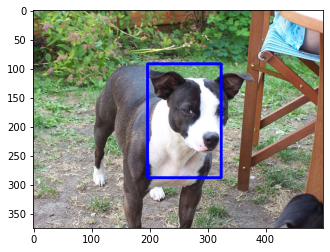

In [49]:
plot_image_with_bbox(test_images[15],bbox, test_width_height[15])